# 📊 ML-Based Trading Strategy

## Introduction

This notebook explores **backtesting Machine Learning-based trading strategies**, focusing on computationally efficient yet effective approaches — such as **Decision Trees**.

The goal is to demonstrate the **pipeline** needed to create such a strategy using a simple model.

As with other experiments in this repository, we leverage **Mini_lib** to streamline key steps in applying ML to financial data. Specifically, we will:

1. **Label the data** — Define the target variable for our ML model.
2. **Generate and analyze features** — Extract meaningful financial indicators.
3. **Train a model** — Apply ML techniques, such as Random Forests, to derive trading signals.
4. **Backtest the strategy** — Assess performance using a robust backtesting framework.

By following this structured approach, we aim to clearly present the core steps involved in developing a Machine Learning-driven trading strategy.

> **Note:**  
> This notebook focuses on illustrating the **ML pipeline** using **Mini_lib**.  
> For **full, production-level strategies**, please refer to the other notebooks in this repository, which implement more advanced methods leveraging way more Mini_lib.  
> Those examples may appear more "abstract" because they emphasize deeper modeling techniques.


In [1]:
import sys
sys.path.append("..")
import Data as dt
import ChevalParesseux_lib as lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## **I. Getting Data and Making Samples**  

The first step in our workflow is to **acquire and preprocess market data**. This involves:  

1. **Fetching historical price data** – Using reliable sources to obtain asset prices.  
2. **Cleaning and preprocessing** – Handling missing values, adjusting for corporate actions, and ensuring consistency.  
   *(Note: The dataset used here is already processed, so we will skip this step.)*  
3. **Creating research samples** – Splitting the data into **Training**, **Testing**, and **Embargo** sets to prevent overfitting.  

### ⚠️ **Important Note**  
A **testing set** should be used **sparingly**! It is recommended to track the number of times it is accessed to prevent data leakage and ensure unbiased model evaluation.  


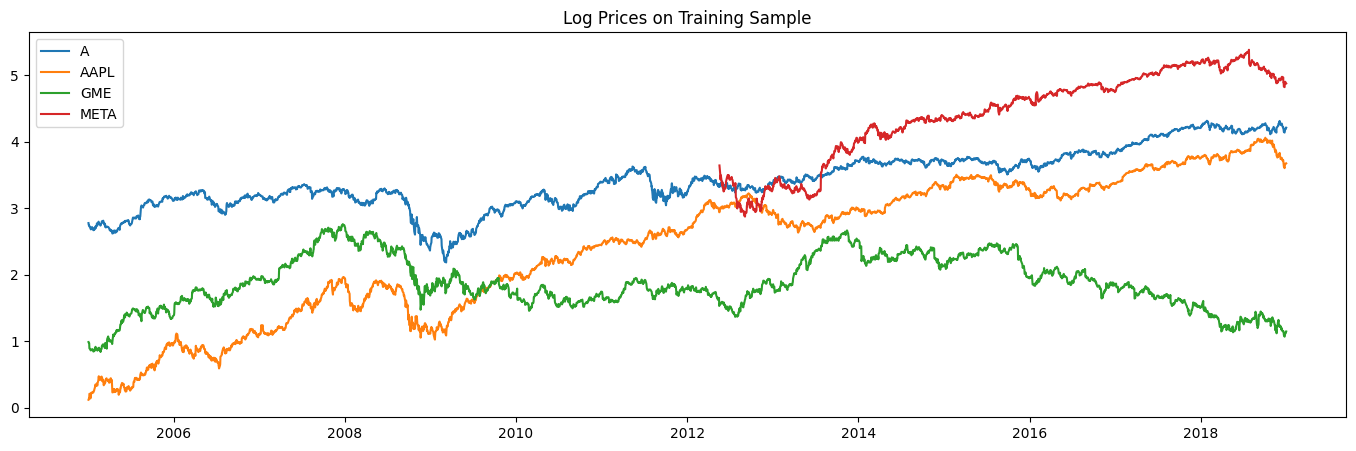

In [2]:
# I. Load data
data = dt.load_dataList(ticker_list=['A', 'AAPL', 'GME', 'META'])

# II. Making Samples
training_data = {}
testing_data = {}
embargo_data = {}

for ticker in data.keys():
    full_df = data[ticker].copy()
    full_df.index = pd.to_datetime(full_df['date'])
    training_data[ticker] = full_df.loc['2005-01-01':'2019-01-01']
    testing_data[ticker] = full_df.loc['2019-01-01': '2023-01-01']
    embargo_data[ticker] = full_df.loc['2023-01-01':]

# III. Let's see the training data we have on a log scale
plt.figure(figsize=(17, 5))
for asset_df in training_data.values():
    plt.plot(np.log(asset_df['close']), label=asset_df['code'].iloc[0])
plt.legend()
plt.title('Log Prices on Training Sample')
plt.show()

### **📈 Correlations Over Time**

Since our strategy involves multiple assets, it's insightful to examine how their **correlations evolve over time**.

Monitoring the dynamics of correlations can help identify periods of market stress, diversification opportunities, or structural changes in asset relationships — all of which are crucial for robust strategy design.


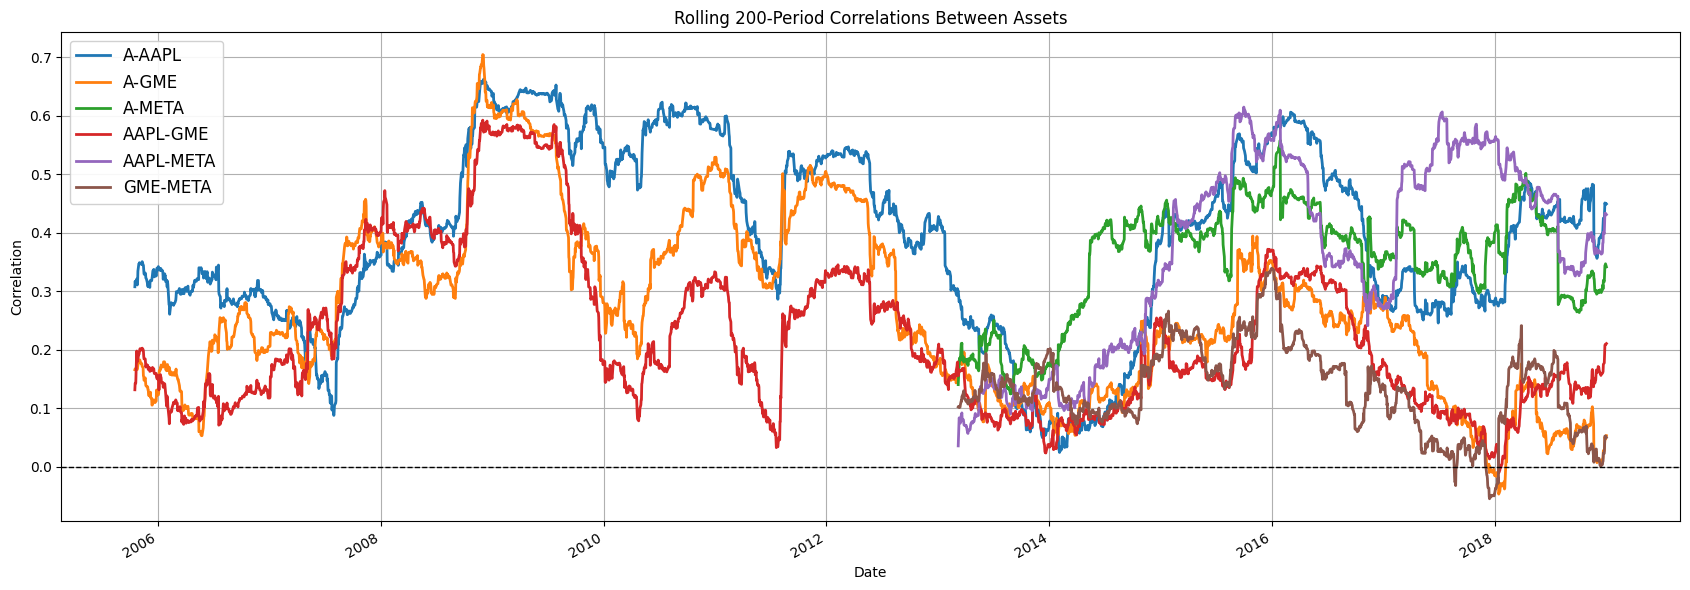

In [ ]:
# ------- I. Group returns data --------
close_df = pd.DataFrame({ticker: asset_df['close'] for ticker, asset_df in training_data.items()})
close_df = close_df 
returns_df = np.log(close_df).diff() 
tickers = returns_df.columns

# ------- II. Compute rolling correlations --------
window = 200  # Rolling window size
rolling_correlations = {}
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        pair = f"{tickers[i]}-{tickers[j]}"
        rolling_correlations[pair] = returns_df[tickers[i]].rolling(window).corr(returns_df[tickers[j]])

rolling_correlation_df = pd.DataFrame(rolling_correlations)

# ------- III. Plot rolling correlations --------
plt.figure(figsize=(17, 6))
rolling_correlation_df.plot(ax=plt.gca(), linewidth=2)
plt.title(f'Rolling {window}-Period Correlations Between Assets')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(loc='upper left', fontsize=12, framealpha=0.9)
plt.grid(True)
plt.tight_layout()
plt.show()

### **Rolling 200-Period Correlations Between Assets**

### General Trends
- **A-AAPL (Blue Line)**: Shows a relatively stable correlation with other assets, with some fluctuations over the years.
- **A-GME (Orange Line)**: Exhibits more volatility in its correlation with other assets, with notable peaks and troughs.
- **A-META (Green Line)**: Displays a moderate level of correlation, with some periods of higher volatility.
- **AAPL-GME (Red Line)**: Shows significant fluctuations, indicating varying degrees of correlation between AAPL and GME over time.
- **AAPL-META (Purple Line)**: Generally follows a similar pattern to AAPL, with some periods of higher correlation.
- **GME-META (Brown Line)**: Exhibits the lowest correlation among the pairs, with frequent drops below 0.2.

### Notable Periods
- **2008-2010**: A significant increase in correlation across most assets, likely due to the financial crisis.
- **2012-2014**: A period of divergence, with some assets showing higher correlation while others decrease.
- **2015-2017**: A general trend of increasing correlation, with some assets reaching peaks above 0.6.

---
## **II. Labelling Data**  

To train our classification models, we need to **define a labeling method** that captures meaningful patterns in price movements.  

### 🎯 **Objective**  
The goal is to assign labels to our dataset that reflect future market conditions, allowing our ML models to learn predictive patterns.  

### 🏷️ **Labeling Approach**  
We apply a **labeling method** to categorize market states based on price behavior. This step is crucial because:  

✅ It transforms raw price data into a structured learning problem.  
✅ It helps the model differentiate between profitable and unprofitable conditions.  
✅ It avoids bias by ensuring well-balanced class distributions.  

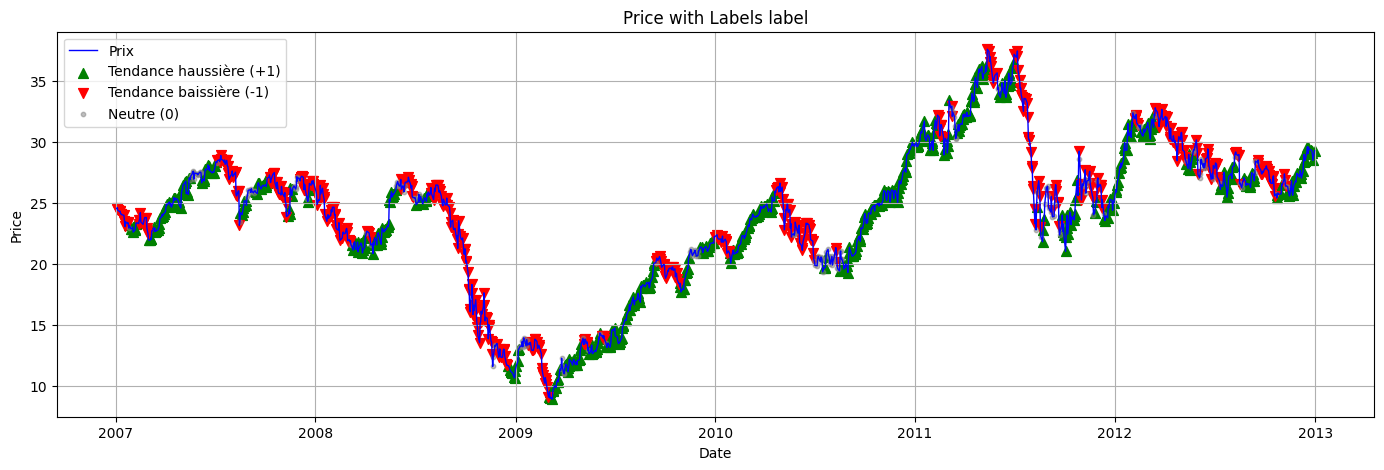

label
 1.0    761
-1.0    567
 0.0    182
Name: count, dtype: int64


In [32]:
tripleBarrier_params = {
    "upper_barrier": [1],
    "lower_barrier": [1.5],
    "vertical_barrier": [20],
    "vol_window": [20],
    "smoothing_method": ["ewma"],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}

idx = 0
for data_set in [training_data, testing_data]:
    for ticker, asset_df in data_set.items():
        df = asset_df.copy()
        close_series = df['close']
        tripleBarrier_labeller = lib.tripleBarrier_labeller(series=close_series, n_jobs=1).set_params(**tripleBarrier_params)
        
        labels_df = tripleBarrier_labeller.extract()
        df.loc[:, 'label'] = labels_df['set_0']

        if idx == 0:
            training_data[ticker] = df
        else:
            testing_data[ticker] = df
    
    idx += 1

asset = 'A'
start_date = '2007-01-01'
end_date = '2013-01-01'
price_series = training_data[asset]['close'].loc[start_date:end_date]
labels = training_data[asset]['label'].loc[start_date:end_date]

lib.plot_price_with_labels(price_series, labels)
print(labels.value_counts())

---
## **III. Feature Exploration**  

In this section, we will **generate and analyze features** to determine if they contain meaningful information for our model.  

### 🔍 **Objective**  
The goal is to create financial indicators that help distinguish different market conditions and improve model predictions.  

### ⚙️ **Feature Engineering Process**  
We will:  
1. **Generate features** – Extract technical, statistical, and market-based indicators.  
2. **Analyze their distributions** – Check for patterns and potential predictive power.  
3. **Assess feature importance** – Determine which features contribute the most to classification.  

In [33]:
features_params = {
    "window": [5, 10, 30, 60, 120],
    "power": [3, 4, 5],
    "quantile": [0.1, 0.9],
    "smoothing_method": [None, "ewma"],
    "window_smooth": [10],
    "lambda_smooth": [0.2],
}

features_model = [
    lib.average_feature, 
    lib.minimum_feature, 
    lib.volatility_feature, 
    lib.quantile_feature, 
    lib.Z_momentum_feature, 
    lib.nonlinear_tempReg_feature, 
    lib.hurst_exponent_feature
]

In [ ]:
training_processed = {}
testing_processed = {}
# ------- Iterate over the training and testing data -------
idx = 0
for data_set in [training_data, testing_data]:
    # ------- Iterate over the assets -------
    for ticker, asset_df in tqdm(data_set.items()):
        df = asset_df.copy()
        close_series = df['close']
        features_list = []
        # ------- Compute each feature class -------
        for feature in features_model:
            model = feature(data=close_series, n_jobs=9)
            model = model.set_params(**lib.filter_params_for_function(model.set_params, features_params))
            feature_df = model.extract()
            features_list.append(feature_df)
        
        # ------- Reconstruct DataFrame -------
        feature_df = pd.concat(features_list, axis=1)
        df = pd.concat([df, feature_df], axis=1)
        
        # ------- Store Processed DataFrame -------
        if idx == 0:
            training_processed[ticker] = df
        else:
            testing_processed[ticker] = df
    
    idx += 1

100%|██████████| 4/4 [01:11<00:00, 17.88s/it]


Correlation Matrix of Labels-Features on A


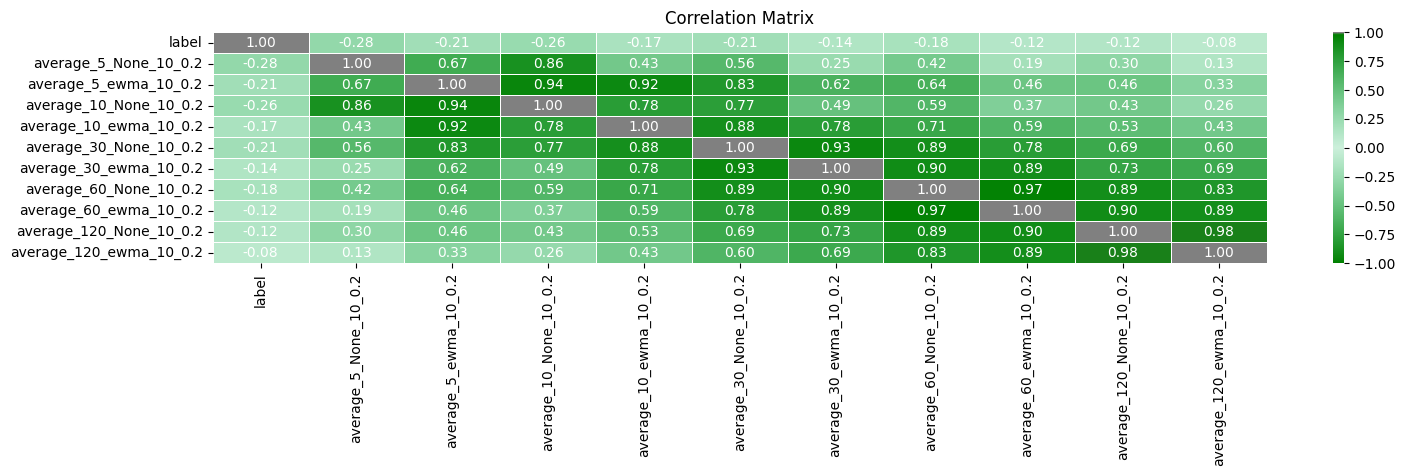

In [37]:
# Let's see the correlation matrix of the features with the labels
features_list = ['label'] + list(training_processed['A'].columns[10:20])

print('Correlation Matrix of Labels-Features on A')
lib.features_correlation(training_processed['A'][features_list])

Data Type: float64
Missing Values: 4, Unique Values: 3519
Zero Values: 0, Negative Values: 1944, Positive Values: 1575


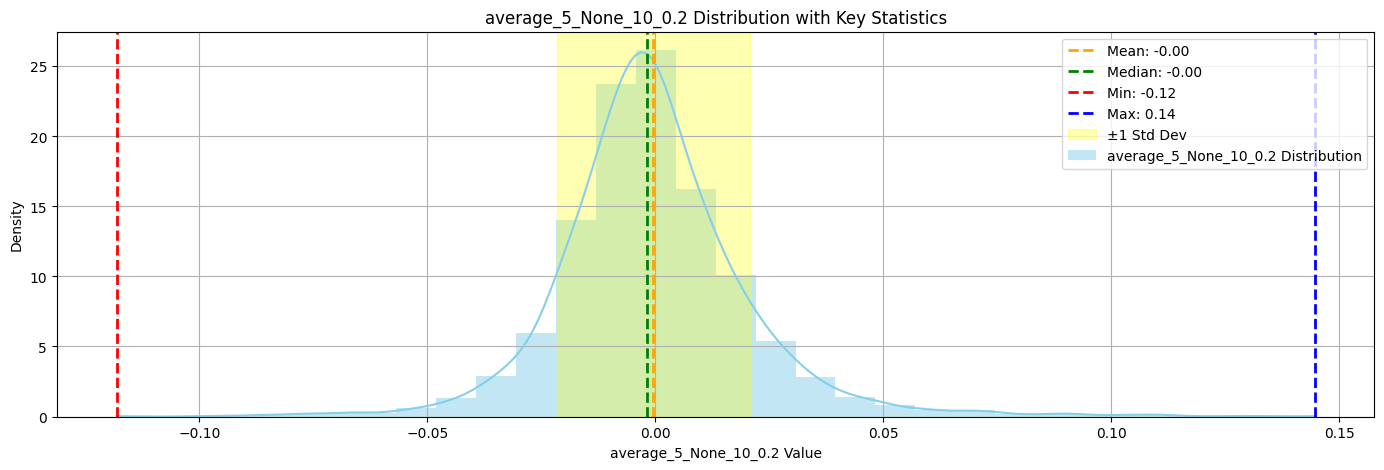

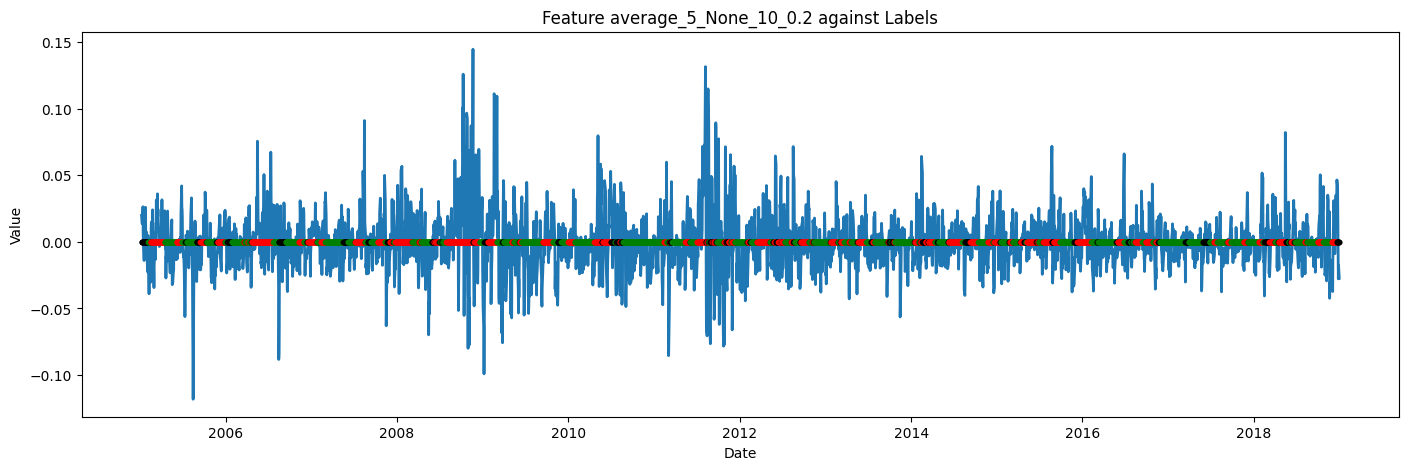

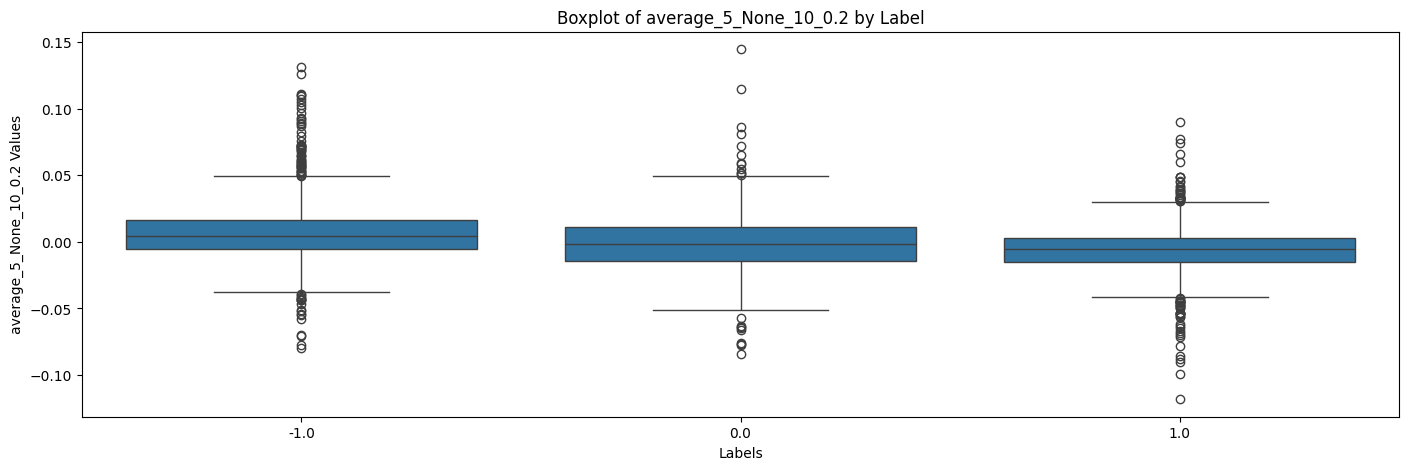

In [36]:
# Let's plot one feature to get some insights
average_5_feature = training_processed['A']['average_5_None_10_0.2']
labels = training_processed['A']['label']

lib.feature_data(feature_series=average_5_feature)
lib.feature_distribution(feature_series=average_5_feature, feature_name='average_5_None_10_0.2')
lib.feature_plot(feature_series=average_5_feature, label_series=labels, feature_name='average_5_None_10_0.2')

### **Feature Analysis Summary**

**Key Properties**
- **Stationarity**: Features are stationary, ensuring consistent statistical properties over time.
- **Correlation with Labels**: Features show some linear correlation with labels, though the separation between classes (especially class 0) is not very clear.

**Preprocessing Recommendations**
- **Standardization**: Standardize features to avoid scale bias (e.g., using Z-score normalization).
- **Multicollinearity Filtering**: Remove highly correlated features to avoid multicollinearity bias (e.g., using VIF or correlation matrices).

---
## **IV. Predictive Model**

In this section, we will train a Machine Learning model to assess the predictive power of our features and labels. The objective is to evaluate whether our dataset enables strong predictive performance and provides meaningful insights.

In [47]:
training_data = [df for df in training_processed.values()]
non_feature_columns = ['date', 'code', 'exchange', 'open', 'high', 'low', 'close', 'volume', 'count_trx', 'label']
cleaner_params = {
    'stationarity_threshold': 0.05,
    'outliers_threshold': 5,
}
cleaner = lib.FeaturesCleaner(training_data=training_data, non_feature_columns=non_feature_columns, n_jobs=9)
cleaner.set_params(**cleaner_params)

stacked_data, processed_data, features_informations, features_rules = cleaner.extract()
print(f'Stacked Data Shape: {stacked_data.shape}')

Stacked Data Shape: (6534, 119)


In [48]:
features_informations

,feature_name,error_proportion,beginning_nans,middle_nans,infinite_indexes,outliers_count,outliers_proportion,outliers_threshold,mean,std,df_index
0,average_5_None_10_0.2,0.0,4,0,0,9,0.002564,0.105427,-0.000694,0.020311,0
1,average_5_ewma_10_0.2,0.0,13,0,0,11,0.003144,0.060589,-0.000940,0.011684,0
2,average_10_None_10_0.2,0.0,9,0,0,10,0.002854,0.158836,-0.001621,0.030371,0
3,average_10_ewma_10_0.2,0.0,18,0,0,12,0.003435,0.118977,-0.001955,0.022864,0
4,average_30_None_10_0.2,0.0,29,0,0,18,0.005178,0.297093,-0.005424,0.054810,0
...,...,...,...,...,...,...,...,...,...,...,...
431,hurst_pvalue_4_ewma_10_0.2,0.0,276,0,0,8,0.005793,0.005796,-0.000062,0.000897,3
432,hurst_exponent5_None_10_0.2,0.0,32,0,0,0,0.000000,0.583669,0.103128,0.096108,3
433,hurst_pvalue_5_None_10_0.2,0.0,283,0,0,14,0.010234,0.000878,-0.000012,0.000116,3
434,hurst_exponent5_ewma_10_0.2,0.0,41,0,0,0,0.000000,0.800998,0.370164,0.086167,3


In [89]:
set_params = {
    'labels_name': 'label',
    'price_name': 'close',
    'n_samples': 5000,
    'replacement': True,
    'vol_window': 20,
    'upper_barrier': 1,
    'vertical_barrier': 20,
}

set_generator = lib.TemporalUniquenessSplitter(training_df=stacked_data, n_jobs=9, random_state=72).set_params(**set_params)
folds, balanced_folds = set_generator.extract(stacked_data)

## **🌳 Decision Tree**

To conclude this notebook, we train a custom Decision Tree on modified training data (resampled by average uniqueness and importance by returns and time, as described by Lopez de Prado). This backtest is simplified and not intended to serve as a full trading strategy. It provides a preliminary insight but lacks the confidence for real-world application.

> ⚠ **Note**: The Decision Tree model is implemented from scratch (see `Mini_lib`). Performance and efficiency may differ from established libraries like `sklearn`.


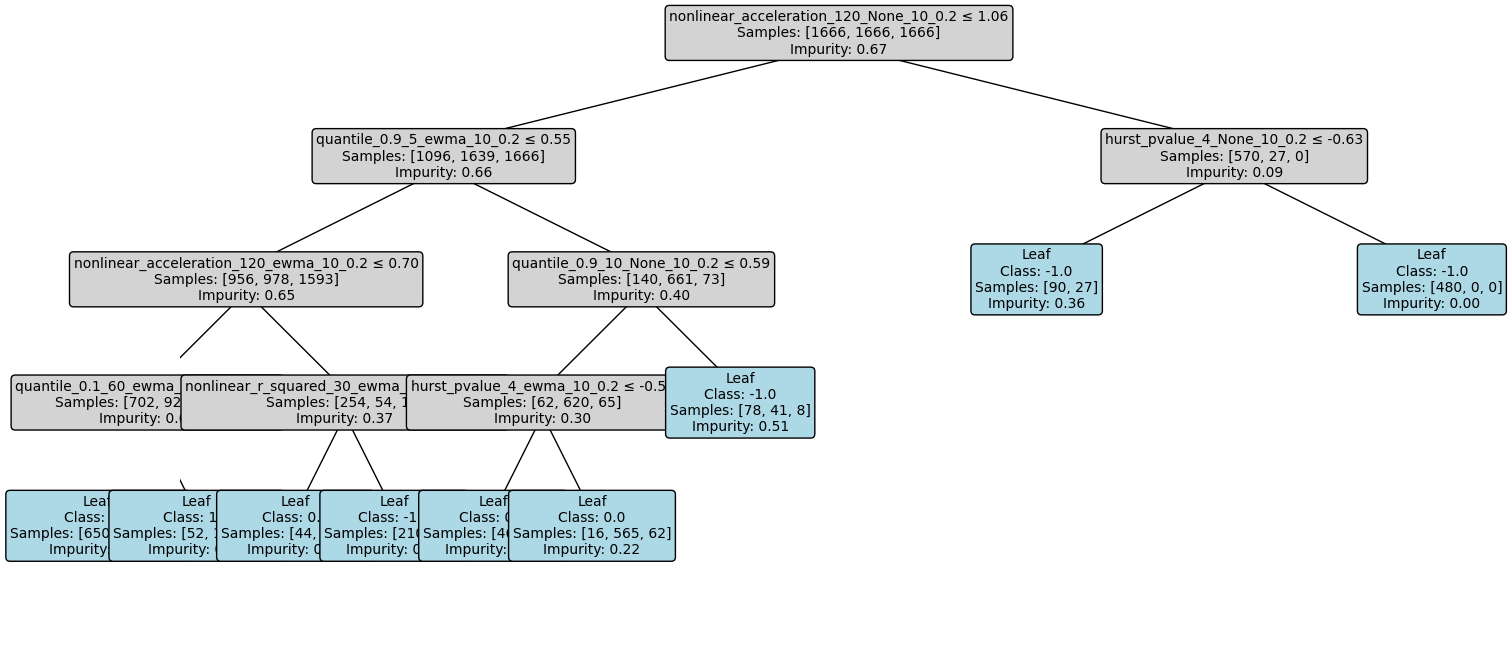

In [93]:
dTree_params = {
    'criterion': 'gini',
    'max_depth': 4,
    'min_samples_split': 100,
    'min_samples_leaf': 100,
    'max_features': 50,
}
X_train = balanced_folds[0].drop(columns=non_feature_columns)
y_train = balanced_folds[0]['label']

model = lib.DecisionTreeClassifier(n_jobs=9, random_state=72)
model.set_params(**dTree_params)
model.fit(X_train, y_train)
lib.plot_tree(model.root, feature_names=X_train.columns.tolist())

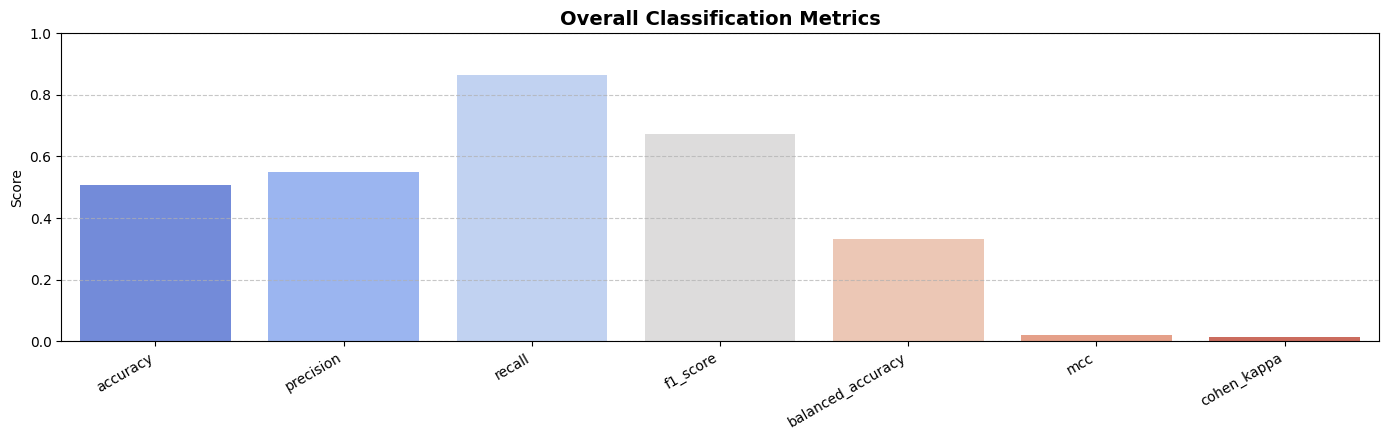

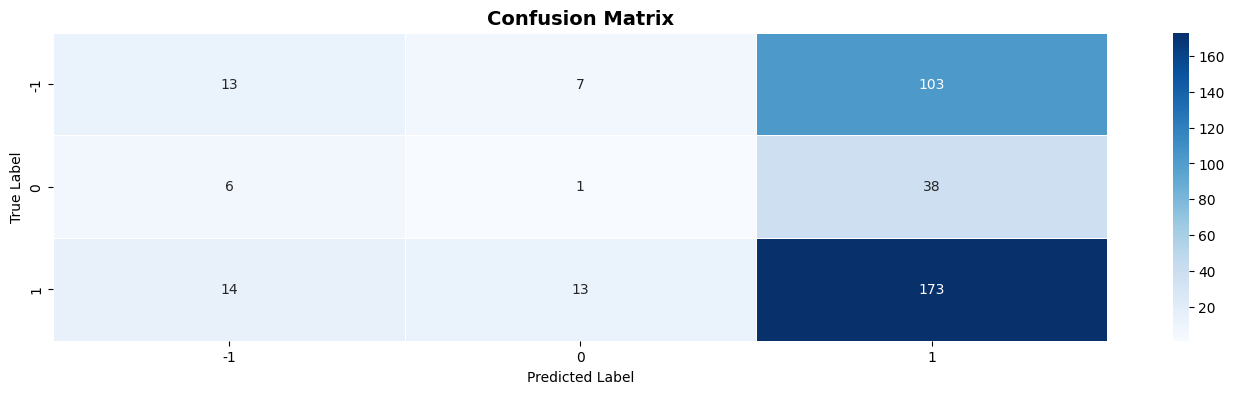

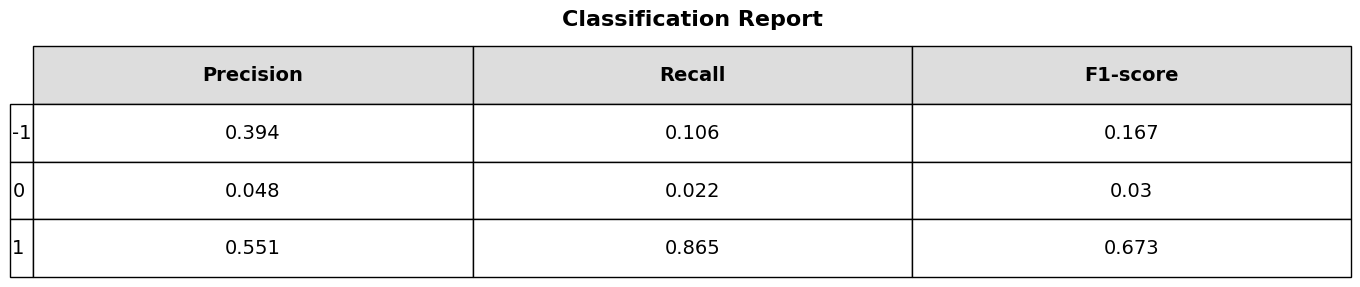

In [104]:
"""Let's see how the model performs on the training set"""
test_data = folds[1].copy()
test_data = test_data.groupby('code')
test_data = [df for _, df in test_data][0]

predictions = model.predict(test_data.drop(columns=non_feature_columns, axis=1))
test_data['predictions'] = predictions
lib.plot_classification_metrics(predictions=test_data['predictions'], labels=test_data['label'], classes=[-1, 0, 1])

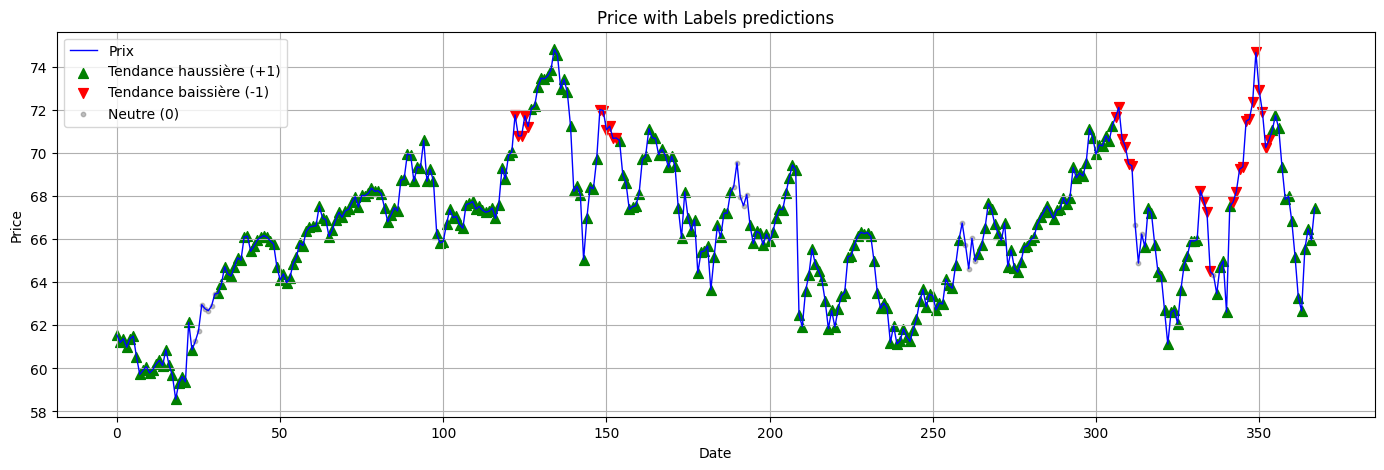

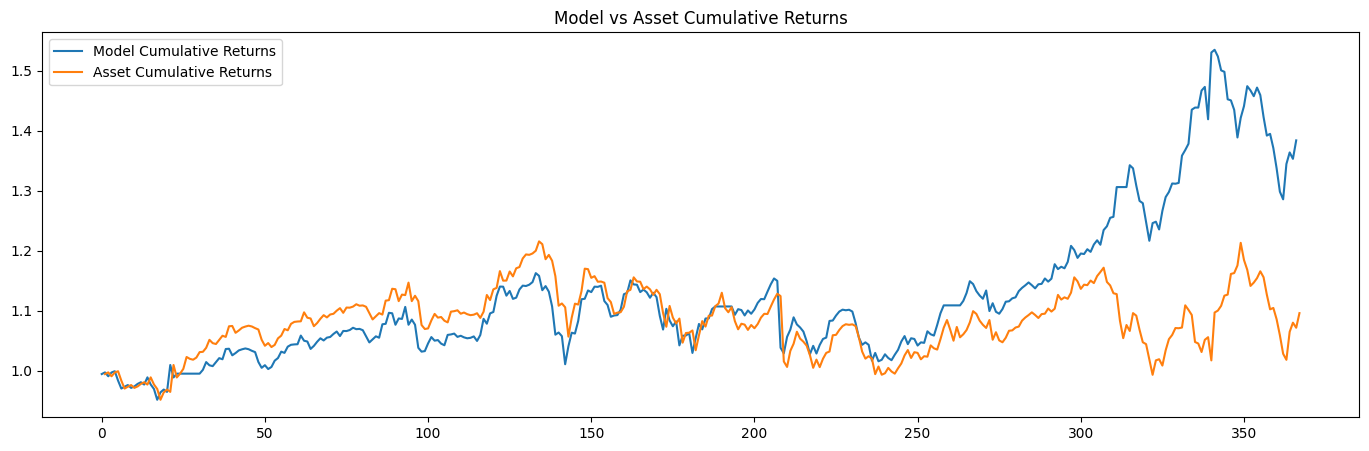

Sharpe Ratio: 1.07, Information Ratio: 0.47, Calmar Ratio: 1.54


In [105]:
lib.plot_price_with_labels(price_series=test_data['close'], label_series=test_data['predictions'])

test_data['asset_returns'] = test_data['close'].pct_change()
test_data['model_returns'] = test_data['predictions'] * test_data['asset_returns'].shift(-1)
test_data['model_cumret'] = (1 + test_data['model_returns']).cumprod()
test_data['asset_cumret'] = (1 + test_data['asset_returns']).cumprod()

plt.figure(figsize=(17, 5))
plt.plot(test_data['model_cumret'], label='Model Cumulative Returns')
plt.plot(test_data['asset_cumret'], label='Asset Cumulative Returns')
plt.title('Model vs Asset Cumulative Returns')
plt.legend()
plt.show()

performance_metrics, _ = lib.get_performance_measures(returns_series=test_data['model_returns'], market_returns=test_data['asset_returns'])
print(f"Sharpe Ratio: {performance_metrics['sharpe_ratio']:.2f}, Information Ratio: {performance_metrics['information_ratio']:.2f}, Calmar Ratio: {performance_metrics['calmar_ratio']:.2f}")

# **Conclusion**

Interestingly, the model behaves as "Hold long, and revert if there's a spike." Despite training on a balanced dataset, it predominantly predicts long positions with very few neutral (0) predictions.

**Reminder**: Even with good metrics, results may stem from "luck" rather than robust predictive power.
